# PMSM motor winding temperature and torque prediction

This project consists of predicting the torque and temperature of the stator windings of a permanent magnet synchronous motor.

### Columns description:

Ambient: Room temperature -
Coolant: coolant temperature -
u_d: d-component voltage -
u_q: q-component voltage -
motor_speed: motor speed -
torque: torque -
i_d: d-component current -
i_q: q-component current -
pm: rotor temperature -
stator_yoke: stator temperature (iron) -
stator_tooth: stator tooth temperature -
stator_winding: stator winding temperature (wire)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
df=pd.read_csv("pmsm_temperature_data.csv")
df

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
998065,-0.047497,0.341638,0.331475,-1.246114,-1.222428,-0.255640,1.029142,-0.245723,0.429853,1.018568,0.836084,0.494725,72
998066,-0.048839,0.320022,0.331701,-1.250655,-1.222437,-0.255640,1.029148,-0.245736,0.429751,1.013416,0.834438,0.494279,72
998067,-0.042350,0.307415,0.330946,-1.246852,-1.222430,-0.255640,1.029191,-0.245701,0.429439,1.002906,0.833936,0.492666,72
998068,-0.039433,0.302082,0.330987,-1.249505,-1.222432,-0.255640,1.029147,-0.245727,0.429558,0.999157,0.830504,0.490581,72


### Data exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ambient         998070 non-null  float64
 1   coolant         998070 non-null  float64
 2   u_d             998070 non-null  float64
 3   u_q             998070 non-null  float64
 4   motor_speed     998070 non-null  float64
 5   torque          998070 non-null  float64
 6   i_d             998070 non-null  float64
 7   i_q             998070 non-null  float64
 8   pm              998070 non-null  float64
 9   stator_yoke     998070 non-null  float64
 10  stator_tooth    998070 non-null  float64
 11  stator_winding  998070 non-null  float64
 12  profile_id      998070 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


No null values are seen, and all columns are numeric.

In [5]:
df.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


<AxesSubplot:>

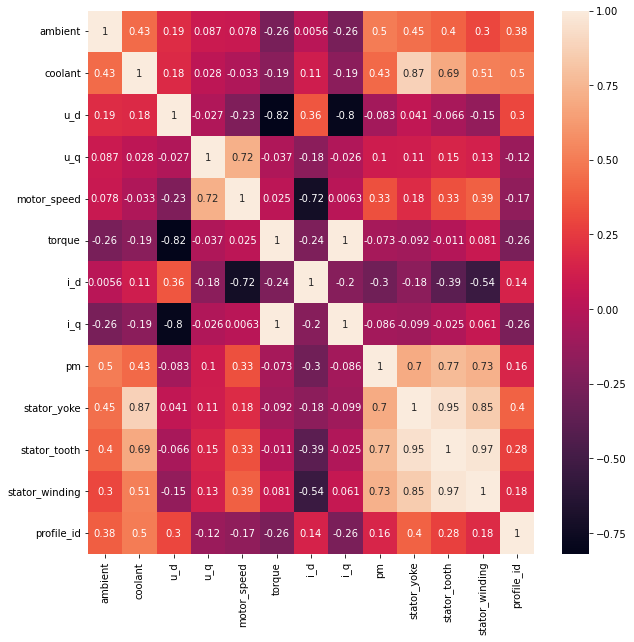

In [6]:
# I plot the correlation between the variables and the targets (torque and stator_winding)
plt.figure(figsize=(10,10))

sns.heatmap(df.corr(),annot=True)

To predict the torque I am going to take the current (i_q) and to predict the temperature of the "stator_winding" I am going to take "stator_yoke" and "coolant".

In [7]:
#I delete the rest of the columns

df=pd.concat([df.stator_yoke, df.stator_winding, df.i_q, df.torque,df.coolant], axis=1)
df.head()

,stator_yoke,stator_winding,i_q,torque,coolant
0,-1.831422,-2.018033,-0.245860,-0.250182,-1.118446
1,-1.830969,-2.017631,-0.245832,-0.249133,-1.117021
2,-1.830400,-2.017343,-0.245818,-0.249431,-1.116681
3,-1.830333,-2.017632,-0.246955,-0.248636,-1.116764
4,-1.830498,-2.018145,-0.246610,-0.248701,-1.116775


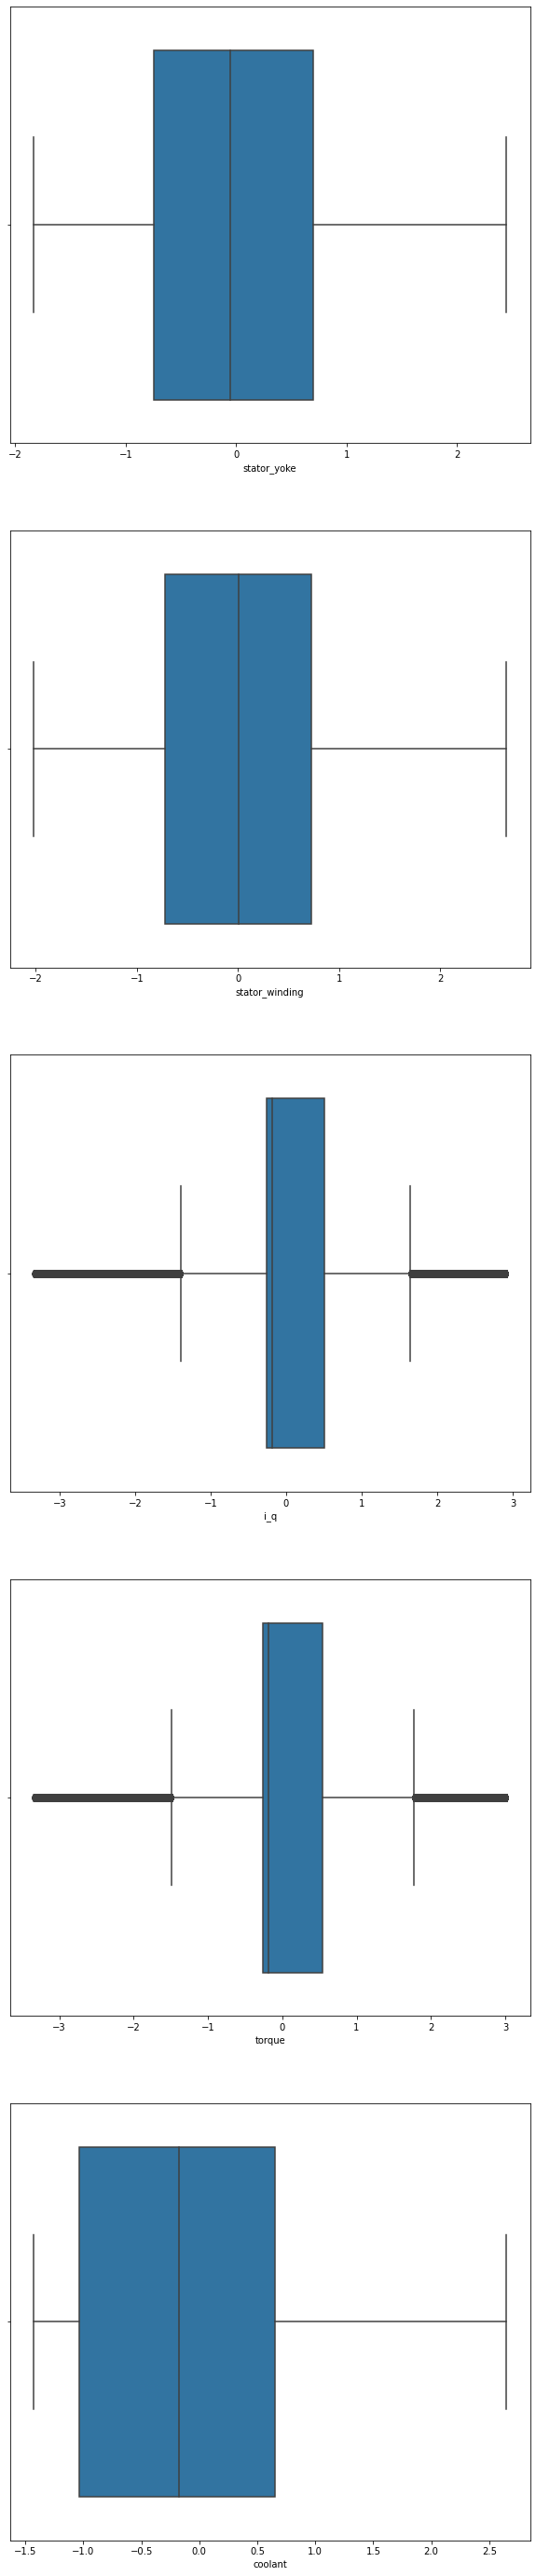

In [8]:
#I plot the outliers.

fig, axis = plt.subplots(5, figsize=(10,50))

j=0
columnas=list(df.columns)
for i in range(0,len(columnas)):
    sns.boxplot(df.iloc[:,i], ax=axis[j])
    j=j+1
    
plt.show()

The sensed values are in the engine's permanent regime, so I estimate that the outliers are errors in the measurement. Therefore I delete them.

In [9]:
#Determination of extreme values
def IRQMinMax(col, d = 1.5, q1 = 0.25, q2 = 0.75):
    q25, q75 = col.quantile(q1), col.quantile(q2)
    irq = q75 - q25
    izq = q25 - irq * d
    der = q75 + irq * d
    return izq, der


In [10]:
minimo_torque, maximo_torque = IRQMinMax(df['torque'])
minimo_i, maximo_i = IRQMinMax(df['i_q'])

In [11]:
df=df[(df.i_q>minimo_i) & (df.i_q<maximo_i)]
df=df[(df.torque>minimo_torque) & (df.torque<maximo_torque)]

df

,stator_yoke,stator_winding,i_q,torque,coolant
0,-1.831422,-2.018033,-0.245860,-0.250182,-1.118446
1,-1.830969,-2.017631,-0.245832,-0.249133,-1.117021
2,-1.830400,-2.017343,-0.245818,-0.249431,-1.116681
3,-1.830333,-2.017632,-0.246955,-0.248636,-1.116764
4,-1.830498,-2.018145,-0.246610,-0.248701,-1.116775
...,...,...,...,...,...
998065,1.018568,0.494725,-0.245723,-0.255640,0.341638
998066,1.013416,0.494279,-0.245736,-0.255640,0.320022
998067,1.002906,0.492666,-0.245701,-0.255640,0.307415
998068,0.999157,0.490581,-0.245727,-0.255640,0.302082


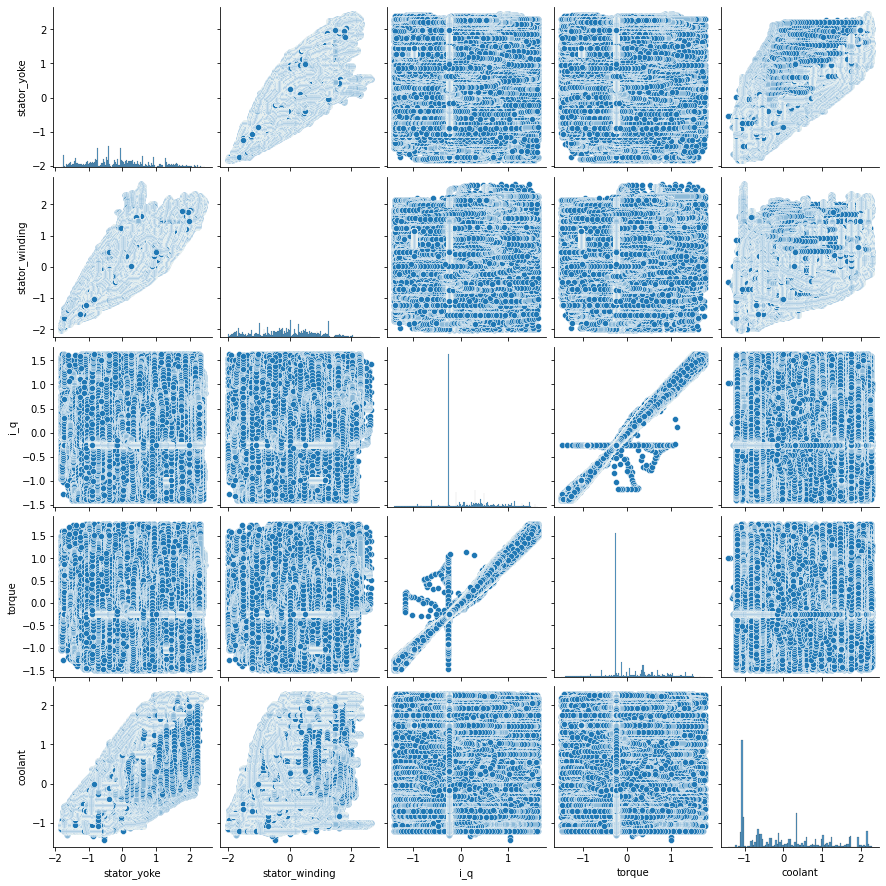

In [12]:
#I plot the relationships between the variables.

sns.pairplot(df)

## Modeling

I'm going to use a linear regression model, a neural network, and a RandomForestRegressor.

## Torque

### Data separation

In [13]:
X=df.i_q.values.reshape(-1,1)
y=df.torque.values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(634756, 1)
(211586, 1)
(634756,)
(211586,)


### Linear regression

In [14]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

#Model training.
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_train_pred_1 = lr.predict(X_train)
y_test_pred_1 = lr.predict(X_test)
print('MSE train data:', mean_squared_error(y_train, y_train_pred_1))
print('MSE test data:', mean_squared_error(y_test, y_test_pred_1))
print('MAE train data:', mean_absolute_error(y_train, y_train_pred_1))
print('MAE test data:', mean_absolute_error(y_test, y_test_pred_1))
print("Score test data:", lr.score(X_test,y_test))

MSE train data: 0.0059997321051605155
MSE test data: 0.005971619456686762
MAE train data: 0.05398585045310204
MAE test data: 0.053980454193829686
Score test data: 0.9852462713139045


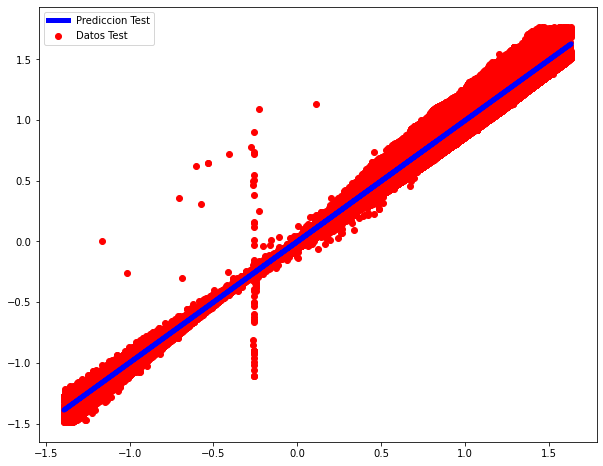

In [16]:
plt.figure(figsize = (10,8))

plt.scatter(X_test, y_test,  color='red', label = 'Datos Test')
plt.plot(X_test, y_test_pred_1, color='blue', linewidth=5.0, label = 'Prediccion Test')

plt.legend()
plt.show()

As you can see, the model is very good

### Neural network

In [23]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

seq = Sequential()
seq.add(Dense(5, activation='relu'))
seq.add(Dense(8, activation='relu'))
seq.add(Dense(8, activation='relu'))
seq.add(Dense(8, activation='relu'))
seq.add(Dense(1, activation='linear'))

In [24]:
seq.compile(optimizer=tf.keras.optimizers.Adam(),loss='mean_squared_error',metrics=['mse'])

In [25]:
seq.fit(X_train, y_train, epochs=10, validation_split=0.25, batch_size=500)

Epoch 1/10
953/953 [==============================] - 3s 2ms/step - loss: 0.0240 - mse: 0.0240 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 2/10
953/953 [==============================] - 3s 3ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 3/10
953/953 [==============================] - 2s 3ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0058 - val_mse: 0.0058
Epoch 4/10
953/953 [==============================] - 3s 3ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 5/10
953/953 [==============================] - 2s 3ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 6/10
953/953 [==============================] - 3s 3ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0057 - val_mse: 0.0057
Epoch 7/10
953/953 [==============================] - 2s 2ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0056 - val_mse: 0.0056
Epoch 8/10
953/953 [==============================] - 2s 3ms/step - loss: 0.

In [26]:
seq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 5)                 10        
                                                                 
 dense_6 (Dense)             (None, 8)                 48        
                                                                 
 dense_7 (Dense)             (None, 8)                 72        
                                                                 
 dense_8 (Dense)             (None, 8)                 72        
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 211
Trainable params: 211
Non-trainable params: 0
_________________________________________________________________


In [28]:
y_train_pred_2 = seq.predict(X_train)
y_test_pred_2 = seq.predict(X_test)

print('MSE test data:', mean_squared_error(y_test, y_test_pred_2))
print('MAE test data:', mean_absolute_error(y_test, y_test_pred_2))

MSE test data: 0.005496310075495993
MAE test data: 0.04825295101399906


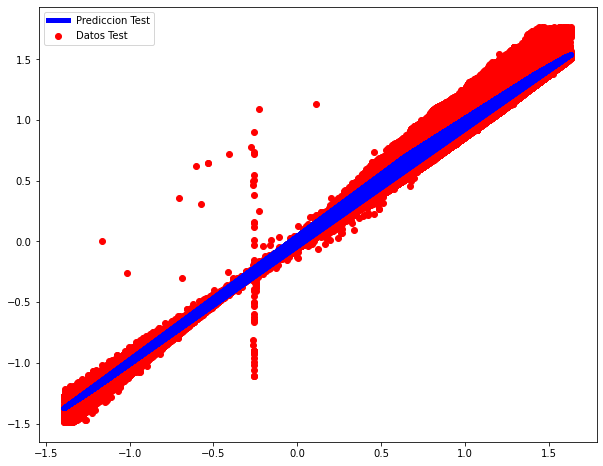

In [29]:
plt.rcParams['agg.path.chunksize'] = 10000
plt.figure(figsize = (10,8))

plt.scatter(X_test, y_test,  color='red', label = 'Datos Test')
plt.plot(X_test, y_test_pred_2, color='blue', linewidth=5.0, label = 'Prediccion Test')

plt.legend()
plt.show()

### RandomForestRegressor

In [31]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state=12)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=12)

In [32]:
y_train_pred_3 = rfr.predict(X_train)
y_test_pred_3 = rfr.predict(X_test)

print('MSE test data:', mean_squared_error(y_test, y_test_pred_3))
print('MAE test data:', mean_absolute_error(y_test, y_test_pred_3))
print("Score test data:", rfr.score(X_test,y_test))

MSE test data: 0.005230344589331385
MAE test data: 0.03535817755075689
Score test data: 0.9870776954952523


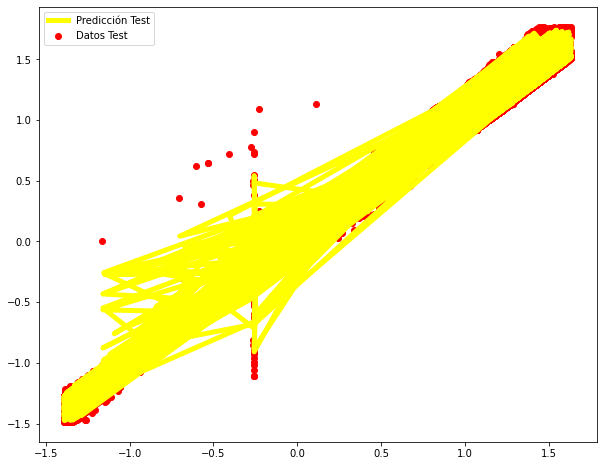

In [33]:
plt.figure(figsize = (10,8))

plt.scatter(X_test, y_test,  color='red', label = 'Datos Test')
plt.plot(X_test, y_test_pred_3, color='yellow', linewidth=5.0, label = 'Predicción Test')

plt.legend()
plt.show()

### Model Comparison

In [34]:
model=["Linear_Regression","Neural Networks","RandomForestRegressor"]
squared_error=[mean_squared_error(y_test, y_test_pred_1), mean_squared_error(y_test, y_test_pred_2), mean_squared_error(y_test, y_test_pred_3)]
absolute_error=[mean_absolute_error(y_test, y_test_pred_1), mean_absolute_error(y_test, y_test_pred_2), mean_absolute_error(y_test, y_test_pred_3)]

MEAN_SQUARED_ERROR


<AxesSubplot:>

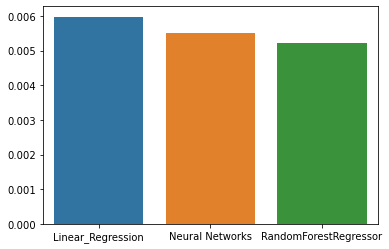

In [35]:
print("MEAN_SQUARED_ERROR")
sns.barplot(x=model, y=squared_error)

MEAN_ABSOLUTE_ERROR


<AxesSubplot:>

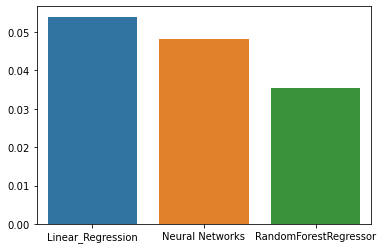

In [36]:
print("MEAN_ABSOLUTE_ERROR")
sns.barplot(x=model, y=absolute_error)

## Winding Temperature.

In [37]:
df.columns

Index(['stator_yoke', 'stator_winding', 'i_q', 'torque', 'coolant'], dtype='object')

In [38]:
X=np.array(df.drop(labels=["stator_winding","i_q","torque"], axis=1))
y=df.stator_winding.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(634756, 2)
(211586, 2)
(634756,)
(211586,)


In [39]:
X

array([[-1.8314217 , -1.1184461 ],
       [-1.8309687 , -1.1170206 ],
       [-1.8304    , -1.1166813 ],
       ...,
       [ 1.0029056 ,  0.30741498],
       [ 0.99915737,  0.3020816 ],
       [ 0.98716253,  0.3126659 ]])

In [40]:
y

array([-2.0180326 , -2.0176313 , -2.0173435 , ...,  0.492666  ,
        0.490581  ,  0.48938242])

### Linear Regression

In [41]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [42]:
y_train_pred_1 = lr.predict(X_train)
y_test_pred_1 = lr.predict(X_test)
print('MSE train data:', mean_squared_error(y_train, y_train_pred_1))
print('MSE test data:', mean_squared_error(y_test, y_test_pred_1))
print('MAE train data:', mean_absolute_error(y_train, y_train_pred_1))
print('MAE test data:', mean_absolute_error(y_test, y_test_pred_1))
print("Score test data:", lr.score(X_test,y_test))

MSE train data: 0.05143937559687614
MSE test data: 0.051422941117238205
MAE train data: 0.1648379756581703
MAE test data: 0.16471923702302824
Score test data: 0.9471908325629136


### Neural Network

In [44]:
seq = Sequential()
seq.add(Dense(5, activation='relu'))
seq.add(Dense(8, activation='relu'))
seq.add(Dense(8, activation='relu'))
seq.add(Dense(8, activation='relu'))
seq.add(Dense(1, activation='linear'))

seq.compile(optimizer=tf.keras.optimizers.Adam(),loss='mean_squared_error',metrics=['mse'])

seq.fit(X_train, y_train, epochs=10, validation_split=0.25, batch_size=500)

Epoch 1/10
953/953 [==============================] - 3s 3ms/step - loss: 0.3436 - mse: 0.3436 - val_loss: 0.1646 - val_mse: 0.1646
Epoch 2/10
953/953 [==============================] - 2s 3ms/step - loss: 0.1069 - mse: 0.1069 - val_loss: 0.0702 - val_mse: 0.0702
Epoch 3/10
953/953 [==============================] - 3s 3ms/step - loss: 0.0565 - mse: 0.0565 - val_loss: 0.0476 - val_mse: 0.0476
Epoch 4/10
953/953 [==============================] - 2s 3ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 5/10
953/953 [==============================] - 2s 2ms/step - loss: 0.0421 - mse: 0.0421 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 6/10
953/953 [==============================] - 2s 2ms/step - loss: 0.0412 - mse: 0.0412 - val_loss: 0.0406 - val_mse: 0.0406
Epoch 7/10
953/953 [==============================] - 2s 3ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.0403 - val_mse: 0.0403
Epoch 8/10
953/953 [==============================] - 3s 3ms/step - loss: 0.

In [45]:
y_train_pred_2 = seq.predict(X_train)
y_test_pred_2 = seq.predict(X_test)

print('MSE test data:', mean_squared_error(y_test, y_test_pred_2))
print('MAE test data:', mean_absolute_error(y_test, y_test_pred_2))

MSE test data: 0.039747018726006424
MAE test data: 0.14280390382722333


### RandomForestRegressor

In [46]:
rfr = RandomForestRegressor(random_state=12)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=12)

In [47]:
y_train_pred_3 = rfr.predict(X_train)
y_test_pred_3 = rfr.predict(X_test)

print('MSE test data:', mean_squared_error(y_test, y_test_pred_3))
print('MAE test data:', mean_absolute_error(y_test, y_test_pred_3))
print("Score test data:", rfr.score(X_test,y_test))

MSE test data: 0.024994884537552085
MAE test data: 0.0906880888549912
Score test data: 0.9743313195640662


### Model comparison

In [48]:
model=["Linear_Regression","Neural Network","RandomForestRegressor"]
squared_error=[mean_squared_error(y_test, y_test_pred_1), mean_squared_error(y_test, y_test_pred_2), mean_squared_error(y_test, y_test_pred_3)]
absolute_error=[mean_absolute_error(y_test, y_test_pred_1), mean_absolute_error(y_test, y_test_pred_2), mean_absolute_error(y_test, y_test_pred_3)]

MEAN_SQUARED_ERROR


<AxesSubplot:>

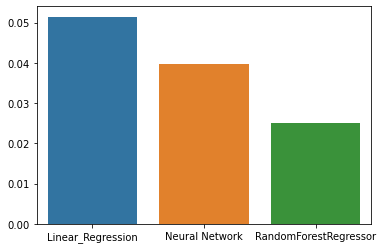

In [49]:
print("MEAN_SQUARED_ERROR")
sns.barplot(x=model, y=squared_error)

MEAN_ABSOLUTE_ERROR


<AxesSubplot:>

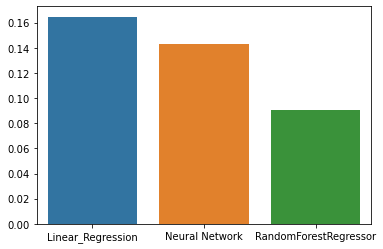

In [50]:
print("MEAN_ABSOLUTE_ERROR")
sns.barplot(x=model, y=absolute_error)

### Conclusion

Although the RandomForest gave a little better, the linear regression did not result much different, and is a much less complex model and faster than RandomForest